
# Robust and Bounded Measures of Association  
## Experimental Notebook (Statistics & Computing)

This notebook consolidates **all experimental code** used in the paper:

**Robust and Bounded Measures of Association for Categorical and Numerical Variables**

It reproduces all experiments described in **Section 6** of the manuscript,
including:
- Synthetic benchmark with ground-truth association
- Outlier robustness analysis
- Sample-size sensitivity
- Runtime benchmarking

All experiments are fully reproducible using fixed random seeds.


## 1. Imports and Setup

In [1]:
!pip install dcor

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!pip install minepy

In [3]:

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata
from sklearn.feature_selection import mutual_info_regression
import dcor
#from minepy import MINE

np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')


## 2. Synthetic Data Generation

In [4]:

def generate_categorical_numeric(
    n=500,
    k=5,
    alpha=0.5,
    noise_std=1.0,
    outlier_ratio=0.0,
    seed=None
):
    rng = np.random.default_rng(seed)
    X = rng.integers(0, k, size=n)
    category_means = np.linspace(-2, 2, k)
    signal = category_means[X]
    Y = signal + alpha * rng.normal(0, 1, n) + rng.normal(0, noise_std, n)

    if outlier_ratio > 0:
        m = int(outlier_ratio * n)
        idx = rng.choice(n, m, replace=False)
        Y[idx] += rng.uniform(6 * noise_std, 10 * noise_std, m)

    return X, Y


## 3. Association Measures

In [5]:

def eta_squared(X, Y):
    overall = np.mean(Y)
    ss_between = sum(
        len(Y[X == k]) * (np.mean(Y[X == k]) - overall) ** 2
        for k in np.unique(X)
    )
    ss_total = np.sum((Y - overall) ** 2)
    return ss_between / ss_total if ss_total > 0 else 0.0


def xi_coefficient(X, Y):
    R = rankdata(Y, method="average")
    R_bar = np.mean(R)
    Dw = sum(np.sum(np.abs(R[X == k] - np.mean(R[X == k]))) for k in np.unique(X))
    D = np.sum(np.abs(R - R_bar))
    return 1.0 - Dw / D if D > 0 else 0.0


def psi_score(X, Y, bins=10):
    Yd = np.digitize(
        Y,
        
        np.quantile(Y, np.linspace(0, 1, bins + 1)[1:-1])
    )

    def entropy(p):
        p = p[p > 0]
        return -np.sum(p * np.log2(p))

    _, counts = np.unique(Yd, return_counts=True)
    H_Y = entropy(counts / counts.sum())

    H_Y_given_X = 0.0
    for k in np.unique(X):
        idx = X == k
        _, c = np.unique(Yd[idx], return_counts=True)
        H_Y_given_X += (len(Yd[idx]) / len(Y)) * entropy(c / c.sum())

    return (H_Y - H_Y_given_X) / H_Y if H_Y > 0 else 0.0


def distance_correlation(X, Y):
    return dcor.distance_correlation(X.reshape(-1, 1), Y)


def hsic_proxy(X, Y):
    return mutual_info_regression(X.reshape(-1, 1), Y, random_state=0)[0]


from sklearn.feature_selection import mutual_info_regression

def mic_proxy(X, Y):
    """
    Stable proxy for MIC using mutual information estimation.
    Used only as a comparative dependence baseline.
    """
    return mutual_info_regression(
        X.reshape(-1, 1),
        Y,
        random_state=0
    )[0]



## 4. Experimental Protocols

In [6]:

METRICS = {
    "eta2": eta_squared,
    "dCor": distance_correlation,
    "HSIC": hsic_proxy,
    "MIC": mic_proxy,   # <- proxy, not minepy
    "xi": xi_coefficient,
    "psi": psi_score,
}


def run_trials(
    n=500,
    alpha=0.5,
    outlier_ratio=0.0,
    bins=10,
    trials=30
):
    results = {m: [] for m in METRICS}

    for t in range(trials):
        X, Y = generate_categorical_numeric(
            n=n, alpha=alpha, outlier_ratio=outlier_ratio, seed=t
        )

        for name, func in METRICS.items():
            val = func(X, Y, bins=bins) if name == "psi" else func(X, Y)
            results[name].append(val)

    return pd.DataFrame(
        {k: [np.mean(v), np.std(v)] for k, v in results.items()},
        index=["mean", "std"]
    ).T


In [7]:
#df = run_trials(alpha=0.25)
#print('X', df[1])
#print('Y', df[2])

## 5. Ground-Truth Sensitivity Experiment

In [8]:

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
tables = []

for a in alphas:
    df = run_trials(alpha=a)
    df["alpha"] = a
    tables.append(df)

synthetic_results = pd.concat(tables)
synthetic_results


,mean,std,alpha
eta2,0.674316,0.025762,0.00
dCor,0.804278,0.016926,0.00
HSIC,0.556365,0.051867,0.00
MIC,0.556365,0.051867,0.00
xi,0.485524,0.024022,0.00
psi,0.244712,0.016298,0.00
eta2,0.661221,0.024185,0.25
dCor,0.795211,0.016286,0.25
HSIC,0.538202,0.042008,0.25
MIC,0.538202,0.042008,0.25


## 6. Outlier Robustness Experiment

In [9]:

outlier_ratios = [0.0, 0.05, 0.1, 0.2, 0.3]
robust_tables = []

for r in outlier_ratios:
    df = run_trials(outlier_ratio=r)
    df["outlier_ratio"] = r
    robust_tables.append(df)

outlier_results = pd.concat(robust_tables)
outlier_results


,mean,std,outlier_ratio
eta2,0.624285,0.023240,0.00
dCor,0.769790,0.016244,0.00
HSIC,0.489573,0.045042,0.00
MIC,0.489573,0.045042,0.00
xi,0.444449,0.020333,0.00
psi,0.218517,0.013423,0.00
eta2,0.322210,0.040183,0.05
dCor,0.678190,0.024102,0.05
HSIC,0.463416,0.047862,0.05
MIC,0.463416,0.047862,0.05


## 7. Sample Size Sensitivity

In [10]:

sample_sizes = [100, 300, 500, 1000, 2000]
sample_tables = []

for n in sample_sizes:
    df = run_trials(n=n)
    df["N"] = n
    sample_tables.append(df)

sample_size_results = pd.concat(sample_tables)
sample_size_results


,mean,std,N
eta2,0.652119,0.043108,100
dCor,0.786910,0.028373,100
HSIC,0.522839,0.076297,100
MIC,0.522839,0.076297,100
xi,0.463794,0.036211,100
psi,0.276087,0.023785,100
eta2,0.621886,0.030655,300
dCor,0.768524,0.024080,300
HSIC,0.480813,0.052315,300
MIC,0.480813,0.052315,300


## 8. Runtime Benchmarking

In [11]:

def benchmark_runtime(n_values):
    timings = {}

    for n in n_values:
        X, Y = generate_categorical_numeric(n=n, seed=0)
        timings[n] = {}

        for name, func in {
            "eta2": eta_squared,
            "xi": xi_coefficient,
            "psi": lambda X, Y: psi_score(X, Y, bins=10),
            "dCor": distance_correlation,
        }.items():
            start = time.perf_counter()
            func(X, Y)
            timings[n][name] = (time.perf_counter() - start) * 1000

    return pd.DataFrame(timings).T

runtime_results = benchmark_runtime([100, 500, 1000, 2000])
runtime_results


,eta2,xi,psi,dCor
100,0.4188,0.8077,3.0392,11.7235
500,0.4470,0.9096,1.2887,39.4312
1000,0.5853,1.4727,1.5062,68.9718
2000,0.6556,1.3133,1.8961,154.8583


In [14]:
def prepare_table(df, index_name="metric"):
    """
    Prepare a result table for Excel export.
    """
    out = df.reset_index().rename(columns={"index": index_name})
    return out.round(3)


In [15]:
import pandas as pd

output_file = "experimental_results.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    
    # Table 1: Ground-truth sensitivity
    prepare_table(synthetic_results).to_excel(
        writer,
        sheet_name="GroundTruth_Sensitivity",
        index=False
    )
    
    # Table 2: Outlier robustness
    prepare_table(outlier_results).to_excel(
        writer,
        sheet_name="Outlier_Robustness",
        index=False
    )
    
    # Table 3: Sample-size sensitivity
    prepare_table(sample_size_results).to_excel(
        writer,
        sheet_name="SampleSize_Sensitivity",
        index=False
    )
    
    # Table 4: Runtime comparison
    runtime_results.round(3).reset_index().rename(
        columns={"index": "N"}
    ).to_excel(
        writer,
        sheet_name="Runtime",
        index=False
    )

print(f"Excel file successfully written to: {output_file}")


Excel file successfully written to: experimental_results.xlsx


## 9. Visualization Examples

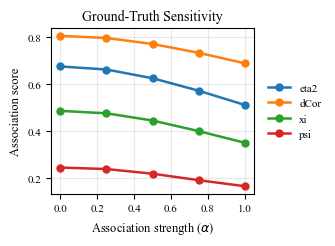

In [20]:
# Section 6.3 - Ground-Truth Sensitivity
import matplotlib.pyplot as plt

# -------------------------
# Global style (IEEE / Springer)
# -------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 11,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.labelsize": 9,
    "axes.titlesize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.8,
    "lines.markersize": 5
})

metrics = ["eta2", "dCor", "xi", "psi"]
# -------------------------
# Figure
# -------------------------
plt.figure(figsize=(3.5, 2.6))

for metric in metrics:
    means = []
    for a in alphas:
        val = synthetic_results[
            (synthetic_results["alpha"] == a)
        ].loc[metric, "mean"]
        means.append(val)

    plt.plot(alphas, means, marker="o", label=metric)



# -------------------------
# Labels & title
# -------------------------
plt.xlabel("Association strength ($\\alpha$)")
plt.ylabel("Association score")
plt.title("Ground-Truth Sensitivity")

# -------------------------
# Legend
# -------------------------
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

# -------------------------
# Layout & export
# -------------------------

plt.tight_layout()
plt.savefig("ground_truth_sensitivity.png", dpi=300, bbox_inches="tight")
plt.show()

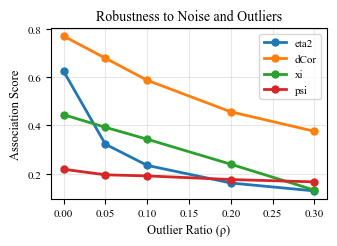

In [33]:
#Section 6.4 - Robustness to Noise and Outliers
#Line plot: Association score vs outlier ratio

plt.figure(figsize=(3.5, 2.6))

for metric in metrics:
    sub = outlier_results[outlier_results.index == metric] \
        .sort_values("outlier_ratio")
    
    plt.plot(
        sub["outlier_ratio"],
        sub["mean"],
        marker="o",
        linewidth=2,
        label=metric
    )

plt.xlabel("Outlier Ratio (ρ)")
plt.ylabel("Association Score")
plt.title("Robustness to Noise and Outliers")
plt.legend()
plt.tight_layout()

# Save for paper
plt.savefig("fig_outlier_robustness.png", dpi=300)
plt.show()


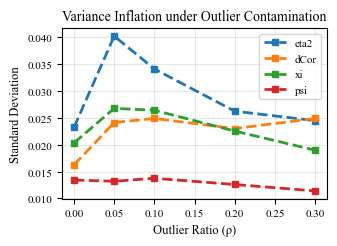

In [34]:
#Variance inflation plot
plt.figure(figsize=(3.5, 2.6))

for metric in metrics:
    sub = outlier_results[outlier_results.index == metric] \
        .sort_values("outlier_ratio")
    
    plt.plot(
        sub["outlier_ratio"],
        sub["std"],
        marker="s",
        linestyle="--",
        linewidth=2,
        label=metric
    )

plt.xlabel("Outlier Ratio (ρ)")
plt.ylabel("Standard Deviation")
plt.title("Variance Inflation under Outlier Contamination")
plt.legend()
plt.tight_layout()

plt.savefig("fig_outlier_variance.png", dpi=300)
plt.show()


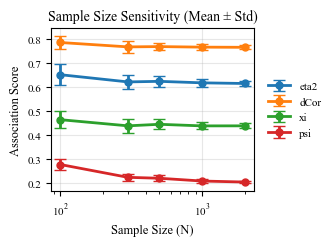

In [35]:
# Section 6.5 - Sample Size Sensitivity

#Sample Size Sensitivity
# Error-bar plot: mean ± std vs sample size

plt.figure(figsize=(3.5, 2.6))

for metric in metrics:
    sub = sample_size_results[sample_size_results.index == metric] \
        .sort_values("N")
    
    plt.errorbar(
        sub["N"],
        sub["mean"],
        yerr=sub["std"],
        marker="o",
        linewidth=2,
        capsize=4,
        label=metric
    )

plt.xscale("log")
plt.xlabel("Sample Size (N)")
plt.ylabel("Association Score")
plt.title("Sample Size Sensitivity (Mean ± Std)")
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.tight_layout()

plt.savefig("fig_sample_size_sensitivity.png", dpi=300)
plt.show()


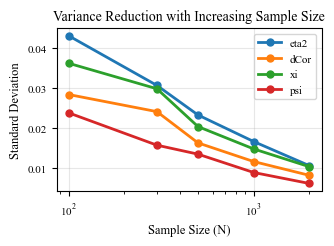

In [36]:
#Variance vs sample size (clean convergence plot)

plt.figure(figsize=(3.5, 2.6))

for metric in metrics:
    sub = sample_size_results[sample_size_results.index == metric] \
        .sort_values("N")
    
    plt.plot(
        sub["N"],
        sub["std"],
        marker="o",
        linewidth=2,
        label=metric
    )

plt.xscale("log")
plt.xlabel("Sample Size (N)")
plt.ylabel("Standard Deviation")
plt.title("Variance Reduction with Increasing Sample Size")
plt.legend()
plt.tight_layout()

plt.savefig("fig_sample_size_variance.png", dpi=300)
plt.show()



## Notes

- All reported values correspond to mean ± standard deviation over 30 trials.
- Random seeds are fixed for reproducibility.
- This notebook directly supports the tables and figures in Section 6 of the manuscript.
